# Compare DexRay with and without Tesseract split

This notebook loads the two models trained on 50k data and compares them.

In [24]:
import csv
import json
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as keras
from tqdm import tqdm

from tesseract.evaluation import predict
from tesseract import evaluation, temporal, metrics, spatial

APK_METADATA_PATH = "/scratch/users/mbenali/metadata.csv"
NUMPY_FILES_DIR = "/scratch/users/mbenali/download_apk/100k_download/npy"
# Where to save all training and testing data after splitting 
DEXRAY_TESSERACT_DATA_DIR = "../reproduce-dexray/data/dexray_tesseract"
DEXRAY_WITHOUT_TESSERACT_DATA_DIR = "../reproduce-dexray/data/dexray_without_tesseract"
YEAR_START = 2010
YEAR_END = 2022

## DexRay without Tesseract

To have a valid comparison, we trained a DexRay model without the time-aware train and test split using
the same 50K APK dataset. Just like for DexRay with Tesseract, we trained and
saved the model, so that we are able to simply load it when we need predictions.

In [25]:
dexray_without_tesseract_model = keras.saving.load_model("../models/model-50k-without-tesseract-10-percent-malware")

We also load the testing data numpy arrays. We have created these when training
the model in `reproduce-dexray/dexray_without_tesseract.py` using the sklearn
`train_test_split` with a 80% training and 20% testing data.

In [26]:
X_test = np.load(os.path.join(DEXRAY_WITHOUT_TESSERACT_DATA_DIR, 'X_test.npy'), allow_pickle=True)
y_test = np.load(os.path.join(DEXRAY_WITHOUT_TESSERACT_DATA_DIR, 'y_test.npy'), allow_pickle=True)

In [27]:
# Reshape testing data to work with the classifier
X_test = X_test.reshape(X_test.shape[0], 16384, 1)

In [28]:
from sklearn.metrics import f1_score

# Get predictions for X_test
y_pred = dexray_without_tesseract_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

313/313 [==============================] - 9s 28ms/step
F1 Score: 0.9916264907383913


We obtain an F1-Score of 0.92. Our F1-Score is likely lower than what is
presented in the DexRay paper, because of
the reduced size of the dataset that we used.

## DexRay with Tesseract

Load the saved model and load the saved training and testing data.

In [29]:
dexray_tesseract_model = keras.saving.load_model("../models/model-50k-tesseract-10-percent-malware")

In [30]:
X = np.load("../reproduce-dexray/data/X.npy", allow_pickle=True)
y = np.load("../reproduce-dexray/data/y.npy", allow_pickle=True)
t = np.load("../reproduce-dexray/data/temp.npy", allow_pickle=True)

### Visualise the temporal distribution of our dataset

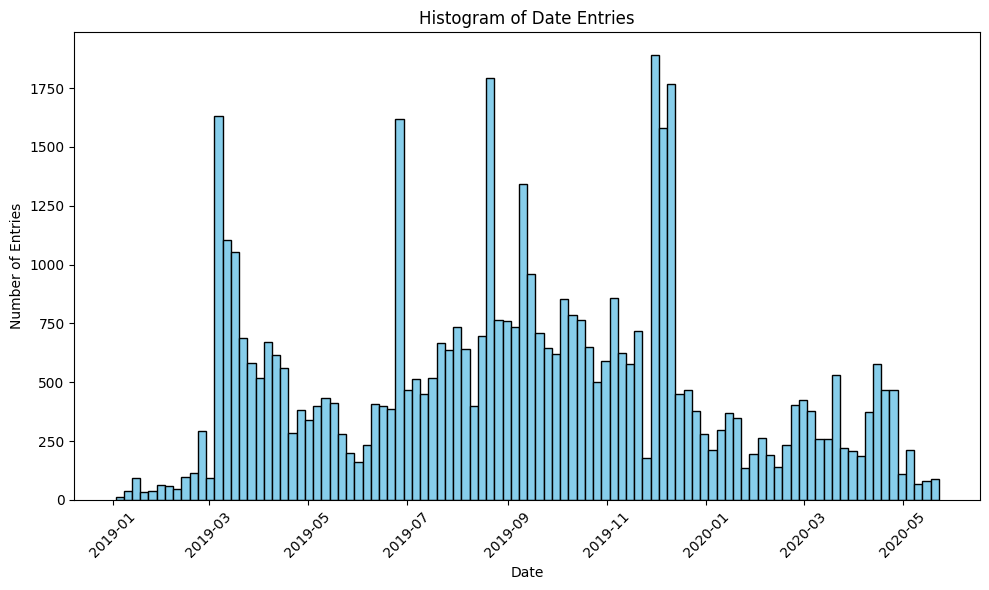

In [31]:
plt.figure(figsize=(10, 6))
plt.hist(t, bins=100, edgecolor='black', color='skyblue')
plt.xlabel('Date')
plt.ylabel('Number of Entries')
plt.title('Histogram of Date Entries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
print(f"The earliest timestamp in the dataset is {t.min()}")
print(f"The latest timestamp in the dataset is {t.max()}")

The earliest timestamp in the dataset is 2019-01-02 18:36:20
The latest timestamp in the dataset is 2020-05-23 02:32:29


We can see that our data is distributed over 17 months, ranging from january
2019 to may 2020. This is in accordance with the time period used in DexRay,
just with fewer samples.

### Partition the dataset

A more detailed description of what `time_aware_train_test_split()` does is in `tesseract-reproduce-drebin`.

In [33]:
X_train, X_test, y_train, y_test, t_train, t_test = temporal.time_aware_train_test_split(X, y, t, train_size=12, test_size=1, granularity='month')

Here, this notebook differs from the others in this folder, because we have
trained the DexRay model beforehand, saved the model, and now we only want to
predict, ie. we want to use `predict()` instead of the `fit_predict_update()`
function used for Drebin and MaMaDroid. 

The code for training the model can be found in
`reproduce-dexray/dexray_tesseract.py`. 

We do it this way, because training the image classifier algorithm used in
DexRay takes while, and splitting training and predicting apart gives us the
ability to save and simply load the model again, instead of having to train it
every time we want to obtain a prediction. Tesseract provides a `predict()`
function as well.

We also use a custom prediction function with Tesseract's `predict()` function,
so that we can turn the probabilities returned by the DexRay classifier into
labels: 

In [34]:
def predict_keras(X_test):
    probabilities = dexray_tesseract_model.predict(X_test, verbose=0)
    return (probabilities > 0.5).astype(int).flatten()  # Convert to 1D array of labels

In [35]:
y_preds = predict(
    dexray_tesseract_model, 
    X_tests=X_test,
    predict_function=predict_keras
)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


In contrast to the `fit_predict_update()` function, `predict()` only returns the
predictions for each sample. To get our results object, we use
`calculate_metrics()` manually.

In [36]:
results = metrics.calculate_metrics(y_test, y_preds, periods=-1)
metrics.print_metrics(results)

------------+-----------------------------------
Test period |     1      2      3      4      5   
------------+-----------------------------------
Actual pos  |    494    390    605   1212    171
Actual neg  |   1079   1218   1256    968    279
Total       |   1573   1608   1861   2180    450
------------+-----------------------------------
TPR         |  0.951  0.959  0.965  0.965  0.971
FPR         |  0.006  0.013  0.014  0.015  0.022
TNR         |  0.994  0.987  0.986  0.985  0.978
FNR         |  0.049  0.041  0.035  0.035  0.029
------------+-----------------------------------
Precision   |  0.987  0.959  0.970  0.987  0.965
Recall      |  0.951  0.959  0.965  0.965  0.971
F1          |  0.969  0.959  0.968  0.976  0.968
------------+-----------------------------------


Since our data does not span over three years, but only one and 5 months, we can
see five periods in our results object. 

In [37]:
metrics.print_metrics(results)

------------+-----------------------------------
Test period |     1      2      3      4      5   
------------+-----------------------------------
Actual pos  |    494    390    605   1212    171
Actual neg  |   1079   1218   1256    968    279
Total       |   1573   1608   1861   2180    450
------------+-----------------------------------
TPR         |  0.951  0.959  0.965  0.965  0.971
FPR         |  0.006  0.013  0.014  0.015  0.022
TNR         |  0.994  0.987  0.986  0.985  0.978
FNR         |  0.049  0.041  0.035  0.035  0.029
------------+-----------------------------------
Precision   |  0.987  0.959  0.970  0.987  0.965
Recall      |  0.951  0.959  0.965  0.965  0.971
F1          |  0.969  0.959  0.968  0.976  0.968
------------+-----------------------------------


### Plotting the results

F1 AUT: 0.9678460538035669
Recall AUT: 0.9626746922023819
Precision AUT: 0.973167854356706


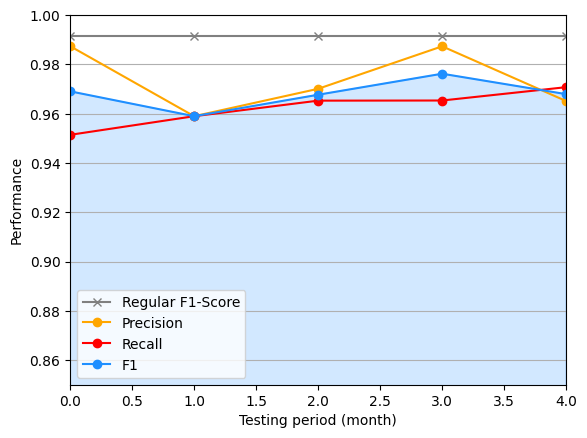

In [38]:
print(f"F1 AUT: {metrics.aut(results, 'f1')}")
print(f"Recall AUT: {metrics.aut(results, 'recall')}")
print(f"Precision AUT: {metrics.aut(results, 'precision')}")

from pylab import *

pendleblue='#1f8fff'
pendleyellow='#ffa600'

regular_f1_score = [f1] * 5

plot(regular_f1_score, marker='x', color='gray')
plot(results['precision'], marker='o', color=pendleyellow)
plot(results['recall'], marker='o', color='red')
plot(results['f1'], marker='o', color=pendleblue)
fill_between(np.arange(0, 5), results['f1'], alpha=0.2, color=pendleblue)
legend(['Regular F1-Score', 'Precision', 'Recall', 'F1'])
xlim([0, 4])
ylim([0.85, 1.0])
xlabel('Testing period (month)')
ylabel('Performance')
grid(axis = 'y')

Surprisingly, the F1-Score obtained by doing a random train and test split is worse than doing Tesseract's time-aware training and testing splits, which shows F1-Scores
between 0.95 and 0.97. The DexRay paper finds the
same indication, it states that DexRay has a F1-Score of 0.96 without a time-aware split
and a F1-Score of 0.98 with a time-aware split.

The reason why the F1-Score is even higher with a time-aware split might be due
to the reduced overall time period of the dataset that was used. 
While Tesseract used three years, we are working with a dataset of only 1 year
and 5 months. Only five months into the future, the malware might not have
changed that much to perceive a drift in the dataset. In the future, it would be
interesting to run DexRay with a time-aware training and testing split on a
dataset that spans over a bigger period of time. 

### 20% Malware in Training 

The above results are obtained from the DexRay classifier trained on 10% of
malware and tested on 10% of malware (as Tesseract says is realistic to assume
in a real world setting). 

Tesseract tunes classifiers by changing the percentage of malware in the
training set. The differences can be seen in Figure 6, which we reproduced in
`tesseract-reproduce-figure6`. 

For DexRay, this was hard to reproduce as well because the training of the model
take a long time. However, we have also trained a DexRay classifier on 20%
of malware in the training set. The following now checks if this changes the
performance of DexRay (still testing with 10% of malware).

In [40]:
dexray_tesseract_20_percent = keras.saving.load_model("../models/model-50k-tesseract-20-percent-malware")

In [41]:
y_preds = predict(
    dexray_tesseract_20_percent, 
    X_tests=X_test,
    predict_function=predict_keras
)

100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


In [42]:
results_20 = metrics.calculate_metrics(y_test, y_preds, periods=-1)
metrics.print_metrics(results_20)

------------+-----------------------------------
Test period |     1      2      3      4      5   
------------+-----------------------------------
Actual pos  |    494    390    605   1212    171
Actual neg  |   1079   1218   1256    968    279
Total       |   1573   1608   1861   2180    450
------------+-----------------------------------
TPR         |  0.951  0.959  0.965  0.965  0.971
FPR         |  0.006  0.013  0.014  0.015  0.022
TNR         |  0.994  0.987  0.986  0.985  0.978
FNR         |  0.049  0.041  0.035  0.035  0.029
------------+-----------------------------------
Precision   |  0.987  0.959  0.970  0.987  0.965
Recall      |  0.951  0.959  0.965  0.965  0.971
F1          |  0.969  0.959  0.968  0.976  0.968
------------+-----------------------------------


F1 AUT: 0.9678460538035669
Recall AUT: 0.9626746922023819
Precision AUT: 0.973167854356706


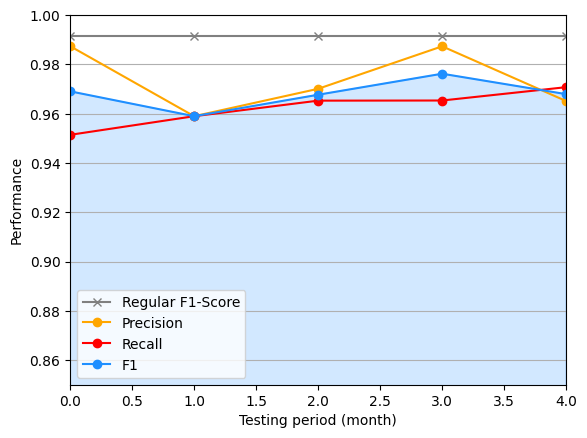

In [43]:
print(f"F1 AUT: {metrics.aut(results_20, 'f1')}")
print(f"Recall AUT: {metrics.aut(results_20, 'recall')}")
print(f"Precision AUT: {metrics.aut(results_20, 'precision')}")

from pylab import *

pendleblue='#1f8fff'
pendleyellow='#ffa600'

regular_f1_score = [f1] * 5

plot(regular_f1_score, marker='x', color='gray')
plot(results_20['precision'], marker='o', color=pendleyellow)
plot(results_20['recall'], marker='o', color='red')
plot(results_20['f1'], marker='o', color=pendleblue)
fill_between(np.arange(0, 5), results['f1'], alpha=0.2, color=pendleblue)
legend(['Regular F1-Score', 'Precision', 'Recall', 'F1'])
xlim([0, 4])
ylim([0.85, 1.0])
xlabel('Testing period (month)')
ylabel('Performance')
grid(axis = 'y')